# Reinforcement Learning

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Devoret

In [3]:
rho = q.ket2dm(np.sqrt(1/3) * q.basis(2,0) + np.sqrt(2/3) * q.basis(2,1))
rho_target = 1/2 * q.ket2dm(q.basis(2,0)+q.basis(2,1))
q.expect(rho, rho_target)

0.9714045207910316

In [4]:
num_qubits = 1
N, M = 100, 100
estimate_fidelity(num_qubits, N, M, rho, rho_target)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6481.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7606.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5877.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6350.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6011.53it/s]

100%|████████████████████████████████████████████████████████████

0.6387999999999999

In [42]:
P_in = q.sigmax()
theoretical_fid = q.expect(P_in, rho)

M = int(1e6)
experimental_fid = estimate_expect(M, P_in, rho)

print(theoretical_fid)
print(experimental_fid)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:56<00:00, 8581.24it/s]

0.9428090415820634
0.943394


In [3]:
from tqdm import tqdm

theoretical_fid = q.expect(rho, rho_target)

num_qubits = 1
dim = 2**num_qubits

random.seed(123)
N = int(1e6)

PAULIS = [q.qeye(2), q.sigmax(), q.sigmay(), q.sigmaz()]
probabilities = [q.expect(pauli, rho_target)**2/dim for pauli in PAULIS]
values = [0, 1, 2, 3]
i_n_list = np.random.choice(values, size=N, p=probabilities)

experimental_fid = 0
for n in tqdm(range(N)):
    i_n = i_n_list[n]
    P_in = PAULIS[i_n]
    
    Pr_in = q.expect(P_in, rho_target)**2/dim
    if Pr_in == 0:
        experimental_fid += 0 
    else:
        experimental_fid += 1/Pr_in * q.expect(rho_target, P_in) * q.expect(rho, P_in)
experimental_fid *= 1/(dim * N)

print(theoretical_fid)
print(experimental_fid)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:04<00:00, 205966.96it/s]

0.9714045207910316
0.9714149295484479


## Alessio

In [2]:
# relaxation
T1 = 6e-3 
relax_rate = 0#1/T1 # relaxation
relax_op = np.sqrt(relax_rate) * q.tensor(q.sigmap(), q.qeye(2))

# dephasing
T2 = 35e-6
deph_rate = 0#(-1/T1+2/T2)/2 # dephasing
deph_op = np.sqrt(0.5 * deph_rate) * q.tensor(q.sigmaz(), q.qeye(2))

rabi_freq = 0.5e6
proj_NV0 = q.ket2dm(q.basis(2,0))
proj_NV1 = q.ket2dm(q.basis(2,1))

def H_Suter():   
    H = (-0.158e6) * q.tensor(proj_NV0, 0.5*q.sigmaz()) + (-0.158e6 + 0.152e6) * q.tensor(proj_NV1, 0.5*q.sigmaz()) + (-0.110e6) * q.tensor(proj_NV1, 0.5*q.sigmax()) 
    return 2 * np.pi * H

def H_MW(phi):
    H = rabi_freq * np.cos(phi)/2 * q.tensor(q.sigmax(), q.qeye(2)) + rabi_freq * np.sin(phi)/2 * q.tensor(q.sigmay(), q.qeye(2))
    return 2 * np.pi * H

def U_free_super(free_time):
    H = H_Suter()
    c_ops = [relax_op, deph_op]
    L = q.liouvillian(H, c_ops)
    return (free_time*L).expm()

def U_pulse_super(pulse_time, phi):
    H = H_Suter() + H_MW(phi)
    c_ops = [relax_op, deph_op]
    L = q.liouvillian(H, c_ops)
    return (pulse_time*L).expm()
    # return scipy.linalg.expm(pulse_time*L.full())

def calc_superop(pulse_seq, num_pulses):
    U = 1
    for i in range(num_pulses):
        free_time, pulse_time, phi = pulse_seq[i], pulse_seq[i+num_pulses], pulse_seq[i+2*num_pulses]
        U = U_pulse_super(pulse_time, phi) * U_free_super(free_time) * U
    if len(pulse_seq) != 3*num_pulses:
        U = U_free_super(pulse_seq[-1]) * U
    return U

In [3]:
num_pulses = 3
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2, 0.89e-6] # Suter Hadamard
superop = calc_superop(pulse_seq, num_pulses)

target_hada = q.tensor(q.qeye(2), q.gates.hadamard_transform())
target_superop = q.tensor(target_hada.conj(), target_hada)
target_superop.dims = [target_hada.dims, target_hada.dims]

calc_fidelity(superop, target_superop)

np.float64(0.9437899973536489)

In [4]:
num_pulses = 3
pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2, 0.63e-6] # Suter CNOT
superop = calc_superop(pulse_seq, num_pulses)

target_cnot = q.tensor(proj_NV0, q.qeye(2))  -1j * q.tensor(proj_NV1, q.sigmax())
target_superop = q.tensor(target_cnot.conj(), target_cnot)
target_superop.dims = [target_cnot.dims, target_cnot.dims]

calc_fidelity(superop, target_superop)

np.float64(0.9797014459277309)

## Lindblad Environment 

In [8]:
import gymnasium as gym

class Parametric_env(gym.Env):
    MAX_STEPS = 2
    INFIDELITY_THRESHOLD = 0.1

    def __init__(self, target_superop):
        self.target_superop = target_superop

        # action and observation spaces
        self.action_space = gym.spaces.Box(low=-1, high= 1, shape=(3,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(512,), dtype=np.float64)

        self.reset()

    def _get_obs(self):
        A = self.superop.full()
        real = A.flatten().real.tolist()
        imag = A.flatten().imag.tolist()
        return np.array(real + imag)

    def reset(self,seed=None, options=None):
        super().reset(seed=seed)
        self.superop = U_free_super(0)
        self.fidelity = calc_fidelity(self.superop, self.target_superop)
        self.count = 0
        self.reward = 0
        self.done = False
        self.duration = 0
        self.observation = self._get_obs()
        self.info = {}

        return self.observation,{}

    def step(self, action):
        if self.done:
            print("EPISODE DONE!!!")
        elif (self.count == self.MAX_STEPS):
            self.done = True
        else:
            assert self.action_space.contains(action)
            self.count += 1
            
        pulse_seq = [
            2.0e-6*np.abs(action[0]), #+ np.abs(0.1),
            2.0e-6*np.abs(action[1]), #+ np.abs(0.1),
            2*np.pi*action[2]
        ]
        superop_layer =  calc_superop(pulse_seq, 1)
        
        self.superop = superop_layer @ self.superop
        self.fidelity = calc_fidelity(self.superop, self.target_superop)
        self.info = {"Fidelity": self.fidelity}

        if 1-self.fidelity < self.INFIDELITY_THRESHOLD:
            self.done = True

        if self.done:
            self.reward = -np.log(1-self.fidelity)
        else:
            self.reward = 0

        self.observation = self._get_obs()

        return (self.observation, self.reward, self.done,self.done, self.info)

In [10]:
target_hada = q.tensor(q.qeye(2), q.gates.hadamard_transform())
target_superop = q.tensor(target_hada.conj(), target_hada)
target_superop.dims = [target_hada.dims, target_hada.dims]

param_env = Parametric_env(target_superop=target_superop) 
param_env.step( [0.74/2, 0.23/2, 3/4] )
param_env.step( [0.22/2, 1.26/2, 3/4] )
param_env.step([0.43/2, 1.50/2, 1/4] )
param_env.step( [0.89/2, 0, 0] )
param_env.fidelity

EPISODE DONE!!!


np.float64(0.9437899973536489)

In [9]:
from stable_baselines3.common.env_checker import check_env

param_env = Parametric_env(target_superop = U_free_super(0))
check_env(param_env, warn=True)

In [10]:
from stable_baselines3 import PPO

target_hada = q.tensor(q.qeye(2), q.gates.hadamard_transform())
target_superop = q.tensor(target_hada.conj(), target_hada)
target_superop.dims = [target_hada.dims, target_hada.dims]

param_env = Parametric_env(target_superop=target_superop)
model = PPO("MlpPolicy", param_env, learning_rate=0.00005,
            gamma=0.99,n_steps=1024,batch_size=256,
            clip_range=0.3, n_epochs=10,ent_coef=0.003, 
            verbose = 1,tensorboard_log="./ppo_cartpole_tensorboard/diss3/").learn(10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_cartpole_tensorboard/diss3/PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | 0.14     |
| time/              |          |
|    fps             | 697      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3            |
|    ep_rew_mean          | 0.166        |
| time/                   |              |
|    fps                  | 665          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 6.786431e-05 |
|    clip_fraction        | 0            |


## Cluster Expansion Environment

In [2]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.getcwd()
filename = os.path.join('baths', 'dominik_bath')
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

kwargs = dict(verbose=False, env_approx_level="gCCE1", bath_configs=bath_configs, suter_method=True, target=bell_state)
env = Environment2(register_config, **kwargs)

In [24]:
env.reset()
env.step_kwargs['instant_pulses'] = True
env.step([2*0/2-1, 2*0.99813568/(2*np.pi)-1, 2*0.69459264/(2*np.pi)-1, 2*148/500-1 ])
env.step([ 2*4.06620465/2-1, 2*3.57557112/(2*np.pi)-1, 2*1.97327426/(2*np.pi)-1, 2*148/500-1])
env.step([2*1.57022726/2-1, 2*1.68300382/(2*np.pi)-1, 2*0.50816523/(2*np.pi)-1, 2*148/500-1])
env.step([2*1.50788214/2-1, 2*0-1, 2*0-1, 2*148/500-1])
env.fidelity

Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.46it/s]


np.float64(0.9853281237513214)

In [25]:
# fidelity calculated the unitary that is returned as observable (does not take into account environmental effects)
rho_evo = q.Qobj( env.U.full() @ q.fock_dm(4, 0).full() @ env.U.dag().full(), dims=env.target.dims )
rho_target = env.target
calc_fidelity(rho_evo, rho_target)

np.float64(0.9997793380086435)

### Training and testing

In [4]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv

# Plotting and monitoring
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

import os
LOG_DIR = os.path.join( os.getcwd(), 'log')
os.makedirs(LOG_DIR, exist_ok=True)

In [30]:
env = Environment2(register_config, **kwargs)
check_env(env, warn=True)

In [39]:
vec_env_test = make_vec_env(lambda:Environment2(register_config, **kwargs), n_envs=1)
vec_env = make_vec_env(lambda:Environment2(register_config, **kwargs), n_envs=2,seed=0, vec_env_cls=SubprocVecEnv)

kwargs = dict(learning_rate=0.00005,gamma=0.9996,n_steps=209,batch_size=209,clip_range=0.2, n_epochs=10,ent_coef=0.001, verbose=1)
model = PPO("MlpPolicy", vec_env, **kwargs)
# tensorboard_log="./ppo_cartpole_tensorboard/diss3/"

Using cpu device


In [40]:
mean_reward, std_reward = evaluate_policy(model, vec_env_test, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward:.2f}")

Mean reward: 0.47828419999999994 +/- 0.00


In [41]:
model.learn(500)
# model.save("ClusterExpansionModel")
# model_loaded = PPO.load("ClusterExpansionModel")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | 0.237    |
| time/              |          |
|    fps             | 36       |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 418      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4             |
|    ep_rew_mean          | 0.243         |
| time/                   |               |
|    fps                  | 36            |
|    iterations           | 2             |
|    time_elapsed         | 23            |
|    total_timesteps      | 836           |
| train/                  |               |
|    approx_kl            | 3.3280212e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | -5.31         |


In [42]:
mean_reward, std_reward = evaluate_policy(model, vec_env_test, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward:.2f}")

Mean reward: 0.4790477 +/- 0.00


In [67]:
obs = vec_env.reset()
n_steps = 4
action_list = []
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic= False)
    action_list.append(action)
    print(f"Step {step + 1}")
    print("Action: ", action)
    obs, reward, done, info = vec_env.step(action)
    print("Reward=", reward)
    print("Fidelity:", info)
    print("------------------------")
    if done.all():
        if info[0]["Fidelity"] > 0.99:
            print("Goal reached", "Fidelity=", info)
        else:
            print(" Max number of layers", "Fidelity=", info[0]["Fidelity"],"Fidelity=",info[1]["Fidelity"])
        break

Step 1
Action:  [[ 1.         -1.          0.73264354 -0.04969397]
 [-0.64323306  1.          0.06673579  1.        ]]
Reward= [0 0]
Fidelity: ({'Fidelity': np.float64(0.4999928008810705), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.5000169211903452), 'TimeLimit.truncated': False})
------------------------
Step 2
Action:  [[-0.2286289 -1.         0.6758448 -1.       ]
 [-0.8009954 -1.         1.         1.       ]]
Reward= [0 0]
Fidelity: ({'Fidelity': np.float64(0.5000007060852723), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.500033354169717), 'TimeLimit.truncated': False})
------------------------
Step 3
Action:  [[-0.10921282 -0.3141937  -0.8903004   0.7381333 ]
 [-0.12162265  0.39209956  1.          0.5643148 ]]
Reward= [0 0]
Fidelity: ({'Fidelity': np.float64(0.11223967195667454), 'TimeLimit.truncated': False}, {'Fidelity': np.float64(0.16687221718643963), 'TimeLimit.truncated': False})
------------------------
Step 4
Action:  [[ 0.7404554  -0.10624398 -0

In [68]:
obs = vec_env_test.reset()
for action in action_list:
    obs, reward, done, info = vec_env_test.step(np.array([action[1]]))
print(reward)

[0.31590217]


### Monitoring

In [5]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq, log_dir, verbose=1):
        
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [6]:
vec_env = Environment2(register_config, **kwargs)

vec_env = Monitor(vec_env, LOG_DIR)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=LOG_DIR)

model_monitor = PPO("MlpPolicy", vec_env, verbose=1)
model_monitor.learn(total_timesteps=5_000, callback=callback)

Using cpu device
Wrapping the env in a DummyVecEnv.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.25
Saving new best model to C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\log\best_model.zip
Num timesteps: 2000
Best mean reward: 0.25 - Last mean reward per episode: 0.23
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | 0.24     |
| time/              |          |
|    fps             | 19       |
|    iterations      | 1        |
|    time_elapsed    | 105      |
|    total_timesteps | 2048     |
---------------------------------
Num timesteps: 3000
Best mean reward: 0.25 - Last mean reward per episode: 0.25
Num timesteps: 4000
Best mean reward: 0.25 - Last mean reward per episode: 0.24
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4           |
|    ep_rew_mean          | 0.244       |
| time/ 

In [7]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

def plot_results(log_dir, title="Learning Curve"):

    x, y = ts2xy(load_results(log_dir), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

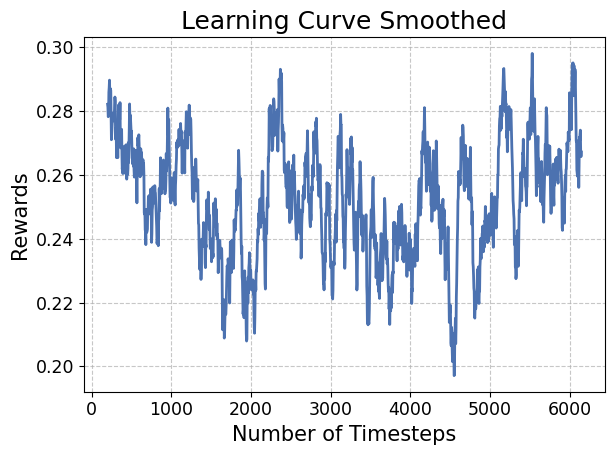

In [8]:
plot_results(LOG_DIR)

## Open Quantum Systems

A good source is Hashim 2024 (https://arxiv.org/abs/2408.12064)

In [ ]:
def calc_process_fidelity(U, U_target):
    """ Calculates the process fidelity in Eq. (237). """
    
    dim = U.shape[0]
    PTM_U = calc_pauli_transfer_matrix([U])
    PTM_U_target = calc_pauli_transfer_matrix([U_target])
    return (PTM_U * PTM_U_target.inv()).tr() / dim**2

# Martinez2020 (10.1109/ACCESS.2020.3025619): amplitude-phase damping (APD) superoperator channel

# gamma = 1-np.exp(-t/T1) # amplitude damping channel, eq.(8)
# lam = 1-np.exp(t/T1-2*t/T2)  # dephasing channel, eq.(13)

# eq. (15)
# E0 = ((1+np.sqrt(1-gamma-(1-gamma)*lam))/2)*Id+((1-np.sqrt(1-gamma-(1-gamma)*lam))/2)*Z # eq.()
# E1 = (np.sqrt(gamma)/2)*X+ 1j*(np.sqrt(gamma)/2)*Y
# E2 = (np.sqrt((1-gamma)*lam)/2)*Id-(np.sqrt((1-gamma)*lam)/2)*Z

# Schlimgen2022 (10.1103/PhysRevResearch.4.023216): eq.(3)